In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
# This dataset was found at https://osu.app.box.com/v/us-accidents-dec19 and unzipped with 7-Zip

In [2]:
df = pd.read_csv('C:/Users/ggibs/data/US_Accidents_Dec19.csv', parse_dates = ['Start_Time', 'End_Time'])  

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Data columns (total 49 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               int64         
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [5]:
# % null
df.isna().sum()/2974335*100

ID                        0.000000
Source                    0.000000
TMC                      24.478446
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
End_Lat                  75.521554
End_Lng                  75.521554
Distance(mi)              0.000000
Description               0.000034
Number                   64.471722
Street                    0.000000
Side                      0.000000
City                      0.002791
County                    0.000000
State                     0.000000
Zipcode                   0.029586
Country                   0.000000
Timezone                  0.106343
Airport_Code              0.191337
Weather_Timestamp         1.234057
Temperature(F)            1.884892
Wind_Chill(F)            62.286965
Humidity(%)               1.989453
Pressure(in)              1.618580
Visibility(mi)            2.208595
Wind_Direction      

In [3]:
# Create a time of traffic duration
df['Duration'] = df.apply(lambda x: x['End_Time'] - x['Start_Time'], axis = 1)
# Convert to minutes
df['Duration'] = df['Duration']/np.timedelta64(1,'m')

In [5]:
# Some records are exactly 30 min to the second and could be placeholders
df['Duration'][df['Duration'] == 30.0000].count()

73849

In [6]:
# Does it correlate to Severity?  No
df['Duration'].corr(df['Severity'])

0.018434961609356315

In [7]:
# Does Distance correlate to Severity?  No
df['Distance(mi)'].corr(df['Severity'])

0.14639349572676352

In [4]:
# Add day of week column
df['weekday'] = df['Start_Time'].apply(lambda x: dt.datetime.strftime(x, '%a'))

         weekday
weekday         
Tue      543,725
Fri      537,749
Wed      537,474
Thu      526,138
Mon      507,255
Sat      170,349
Sun      151,645


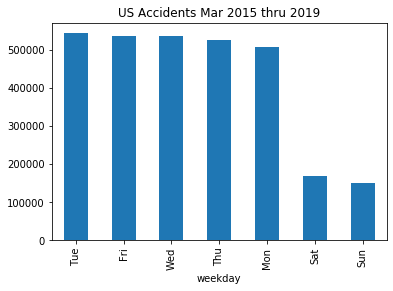

In [9]:
# Distribution of accidents Day of Week
# Fairly even distribution on the five weekdays, each over 500,000 accidents, with Monday 93% of Tuesday's high.
weekday_count = pd.DataFrame(df.groupby('weekday').weekday.count().sort_values(ascending = False))
weekday_count.plot(kind='bar', legend=None, title = 'US Accidents Mar 2015 thru 2019')
plt.show
weekday_count['weekday'] = weekday_count['weekday'].astype(int).apply(lambda x: "{:,}".format(x)) 
print(weekday_count)

In [5]:
# Add hour column
df['hour'] = df['Start_Time'].apply(lambda x: dt.datetime.strftime(x, '%H'))

         hour
hour         
08    284,274
07    273,506
17    221,641
16    212,576
15    177,655
09    177,468
06    169,079
18    167,411
10    157,867
11    155,330
14    150,242
13    142,027
12    139,166
19    115,413
05     83,866
20     81,733
21     57,739
04     53,594
22     48,299
23     26,716
00     23,189
02     18,944
03     18,600
01     18,000


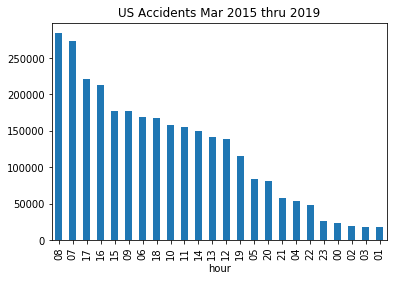

In [11]:
# Distribution of accidents by hour of day
# Commuting time ranks highest, 8AM & 7AM, followed by 5PM & 4PM
hour_count = pd.DataFrame(df.groupby('hour').hour.count().sort_values(ascending = False))
hour_count.plot(kind='bar', legend=None, title = 'US Accidents Mar 2015 thru 2019')
plt.show
hour_count['hour'] = hour_count['hour'].astype(int).apply(lambda x: "{:,}".format(x)) 
print(hour_count)

In [12]:
# It can rain during good weather indicator
subset = (df['Weather_Condition'].isin(['Fair', 'Clear'])) & (df['Precipitation(in)']>0.1) 
WCFair = df[['Weather_Condition', 'Precipitation(in)']][subset]
print(WCFair.head(10))

       Weather_Condition  Precipitation(in)
141205             Clear               0.15
141626             Clear               0.12
141635             Clear               0.12
143251             Clear               0.12
143252             Clear               0.12
143260             Clear               0.12
145692              Fair               0.12
153781             Clear               0.14
159337             Clear               0.14
193080             Clear               0.14


In [13]:
# End_Lat & _Lng are 75.5% null
# Can records have Distance without End coordinates?  Yes
df[(df['End_Lat'].isnull() == True) & (df['Distance(mi)'] > 0.1)].shape

(132433, 52)

In [14]:
# Can Distance be zero and End_Lat not null?  Yes
df[(df['End_Lat'].notnull() == True) & (df['Distance(mi)'] == 0)].shape
# End_Lat and End_Lng are not required.

(152280, 52)

In [ ]:
# Street Number is 64.5% null and not required, considering highways and ramps, etc., do not have a street address.

In [15]:
# TMC is 24.5% null, while 63.5% of available points are in one category, and likely not beneficial.
# % in TMC categories
df.TMC.value_counts()/2974335*100

201.0    63.544860
241.0     7.365377
245.0     1.207631
229.0     0.761616
203.0     0.564563
222.0     0.422010
244.0     0.375311
406.0     0.318290
246.0     0.213493
202.0     0.203306
343.0     0.195909
247.0     0.155194
236.0     0.071142
206.0     0.038899
248.0     0.034024
339.0     0.026023
341.0     0.016945
336.0     0.002723
200.0     0.002219
239.0     0.001816
351.0     0.000202
Name: TMC, dtype: float64

In [53]:
# Exclude End_Lat, End_Lng, Number (street), and TMC columns
df2 = df.drop(['End_Lat', 'End_Lng', 'Number', 'TMC'], axis = 1)
df2.shape

(2974335, 48)

In [17]:
# Drop NaN records
df_nonan = df2.dropna()
df_nonan.shape

(779721, 48)

In [18]:
# Current subset with no NaN is 26% of original file
round(779721 / 2974335 *100,1)

26.2

In [ ]:
# Original file was over 60% null in Precipitation(in) and Wind_Chill(F)
# Here is an alternative effort to salvage a greater proportion of records:
# Sort on month and zipcode to group similar weather together and replace NaNs with interpolate.

In [54]:
# Zipcode is null in only 0.03% of records, remove null zipcode rows
df2 = df2[df2['Zipcode'].notna()]

In [55]:
# Shorten zipcode for larger areas
df2['Zip2'] = df2['Zipcode'].str[:2]

In [56]:
# Extract month
df2['Month'] = df2['Start_Time'].dt.month

In [57]:
# Sort by Month and Zip code to group similar weather
df2.sort_values(by = ['Month', 'Zip2'], inplace = True)

In [58]:
# Interpolate to fill missing records in Precipitation, Wind_Chill and Wind_Speed
cols = ['Precipitation(in)', 'Wind_Chill(F)', 'Wind_Speed(mph)']
df2[cols] = df2[cols].interpolate(method ='linear', axis = 0, limit_direction = 'both') 

In [59]:
df2['Precipitation(in)'].isna().sum()

0

In [68]:
df2 = df2.dropna()

In [70]:
# Retained 97% of records
df2.shape

(2881492, 50)

In [72]:
df2_copy = df2.copy()

In [73]:
# remove outliers
from scipy import stats

def drop_numerical_outliers(df, z_thresh=3):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include='float64') \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, result_type='reduce') \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

In [74]:
drop_numerical_outliers(df2_copy)

In [75]:
# Removing outliers leaves 91.4% of original record count
df2_copy.shape

(2717404, 50)